In [25]:
import pandas as pd

In [26]:
# Load the data from a CSV file
df = pd.read_csv('player_match_ratings.csv')

# Display the first few rows of the dataframe
print(df.head())

  competition        date                    match    team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  France  Sub      Sub   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   FW       FW   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   

              player  goals  assists  shots_ontarget  ...  betweenness2goals  \
0    Anthony Martial      0        0               1  ...           0.000000   
1     Olivier Giroud      1        0               2  ...           0.050000   
2  Laurent Koscielny      0        0               0  ...           0.000000   
3       N'Golo Kante      0        1               0  ...           0.032258   
4         Paul Pogba      0        0               1  ...           0.000000   

   win  lost  is_home_team  minutesPlayed  game_duration  non_

In [27]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # how much opponent difficulty shifts expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m): 
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

# ------------------
# Load & prep
# ------------------
pm = pd.read_csv("player_match_ratings.csv")

# Ensure proper dtypes & order
pm["date"] = pd.to_datetime(pm["date"], errors="coerce")
pm = pm.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Performance P = average of human & non-human notes (ignore NaNs)
pm["P"] = pm[["human_rating", "non_human_rating"]].mean(axis=1)

# Minutes weighting
pm["w_min"] = pm["minutesPlayed"].apply(minutes_weight)

# Competition-wise max rank to scale opponent_ranking → difficulty in [0,1]
max_rank_df = (
    pm.groupby("competition", dropna=False)["opponent_ranking"]
      .max()
      .rename("max_rank")
      .reset_index()
)
pm = pm.merge(max_rank_df, on="competition", how="left")
pm["difficulty"] = pm.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Elo-like update loop
# ------------------

def compute_ratings(pm, K=0.35, DIFF_IMPACT=1.0):
    # pm : DataFrame player_match_ratings
    player_rating = {}
    history = []

    for row in pm.itertuples(index=False):
        player = row.player
        perf   = row.P
        w_min  = row.w_min
        diff   = row.difficulty
        date   = row.date
        match  = row.match

        R_old = player_rating.get(player, BASE_NOTE)

        if pd.isna(perf):
            history.append((date, match, player, R_old, np.nan, np.nan, R_old))
            continue

        E = expected_performance(BASE_NOTE, diff, DIFF_IMPACT)
        delta = K * w_min * (perf - E)
        R_new = R_old + delta

        player_rating[player] = R_new
        history.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(history, columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings


top_20    = final_ratings.sort_values("final_rating", ascending=False).head(20)
bottom_20 = final_ratings.sort_values("final_rating", ascending=True).head(20)


print(top_20)
print(bottom_20)


                player  final_rating
260    Kevin De Bruyne     28.443017
137        Eden Hazard     22.979437
355      Mohamed Salah     20.222572
285         Leroy Sane     19.615598
449      Sergio Aguero     18.679780
178         Harry Kane     18.056165
113        David Silva     17.517424
84   Christian Eriksen     17.281103
413    Raheem Sterling     16.764563
419       Riyad Mahrez     15.504746
363              Naldo     15.234692
421    Roberto Firmino     14.596833
435         Salif Sane     14.468129
201    James Rodriguez     14.250445
510      Wilfried Zaha     14.143780
451        Shane Duffy     14.125703
153        Fernandinho     14.014056
54             Ben Mee     13.916350
244     Joshua Kimmich     13.855334
179      Harry Maguire     13.598122
                  player  final_rating
61            Bobby Wood      0.156378
521           Yuya Osako      0.772563
169          Gideon Jung      0.833719
356  Morgan Schneiderlin      0.898393
323        Martin Olsson    

In [28]:
for K_test in [0.2, 0.35, 0.5]:
    for diff_test in [0.5, 1.0, 1.5]:
        ratings_ts, final_ratings = compute_ratings(pm, K=K_test, DIFF_IMPACT=diff_test)
        top5 = final_ratings.sort_values('final_rating', ascending=False).head(5)
        print(f"\nK={K_test}, DIFF_IMPACT={diff_test} -> Top 5 players:")
        print(top5[['player', 'final_rating']])



K=0.2, DIFF_IMPACT=0.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.912187
137      Eden Hazard     13.318919
355    Mohamed Salah     12.678746
113      David Silva     12.169670
178       Harry Kane     11.993704

K=0.2, DIFF_IMPACT=1.0 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.722714
137      Eden Hazard     13.333364
355    Mohamed Salah     12.461904
285       Leroy Sane     11.935840
178       Harry Kane     11.686101

K=0.2, DIFF_IMPACT=1.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.533240
137      Eden Hazard     13.347808
355    Mohamed Salah     12.245062
285       Leroy Sane     12.002273
449    Sergio Aguero     11.627945

K=0.35, DIFF_IMPACT=0.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     22.651286
137      Eden Hazard     18.113067
355    Mohamed Salah     16.992765
113      David Silva     16.101880
178       Harry Kane     1

In [29]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # how much opponent difficulty shifts expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

def compute_ratings(pm, K=K, diff_impact=DIFF_IMPACT):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    for row in pm.itertuples(index=False):
        player = row.player
        perf   = row.P
        w_min  = row.w_min
        diff   = row.difficulty
        date   = row.date
        match  = row.match

        R_old = player_rating.get(player, BASE_NOTE)

        if pd.isna(perf):
            history.append((date, match, player, R_old, np.nan, np.nan, R_old))
            continue

        E = expected_performance(BASE_NOTE, diff, diff_impact)
        delta = K * w_min * (perf - E)
        R_new = R_old + delta

        player_rating[player] = R_new
        history.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(history, columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep (once)
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty from opponent rank, scaled per competition
max_rank_df = (
    pm0.groupby("competition", dropna=False)["opponent_ranking"]
       .max().rename("max_rank").reset_index()
)
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average of human & non-human (ignores NaNs automatically)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings for each system
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg)
ts_hum, fin_hum = compute_ratings(pm_hum)
ts_ai,  fin_ai  = compute_ratings(pm_ai)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save two CSVs
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

# (optional)
print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")


Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv


In [47]:
# Show the 10 best players by each rating system
print("Top 10 by average note:")
print(final_all.sort_values("final_rating_avg", ascending=False)[["player", "final_rating_avg"]].head(10))

print("\nTop 5 by human note:")
print(final_all.sort_values("final_rating_human", ascending=False)[["player", "final_rating_human"]].head(5))

print("\nTop 5 by non-human note:")
print(final_all.sort_values("final_rating_ai", ascending=False)[["player", "final_rating_ai"]].head(5))

Top 10 by average note:
                player  final_rating_avg
260    Kevin De Bruyne         22.319707
137        Eden Hazard         18.138345
355      Mohamed Salah         16.613291
285         Leroy Sane         15.692678
178         Harry Kane         15.255636
113        David Silva         15.221047
449      Sergio Aguero         15.096348
413    Raheem Sterling         14.536032
84   Christian Eriksen         14.334233
363              Naldo         13.040830

Top 5 by human note:
              player  final_rating_human
260  Kevin De Bruyne           23.581448
355    Mohamed Salah           17.306502
113      David Silva           16.659118
285       Leroy Sane           16.172174
413  Raheem Sterling           15.975707

Top 5 by non-human note:
              player  final_rating_ai
260  Kevin De Bruyne        21.057966
137      Eden Hazard        20.825093
178       Harry Kane        17.892283
355    Mohamed Salah        15.920080
449    Sergio Aguero        15.591358


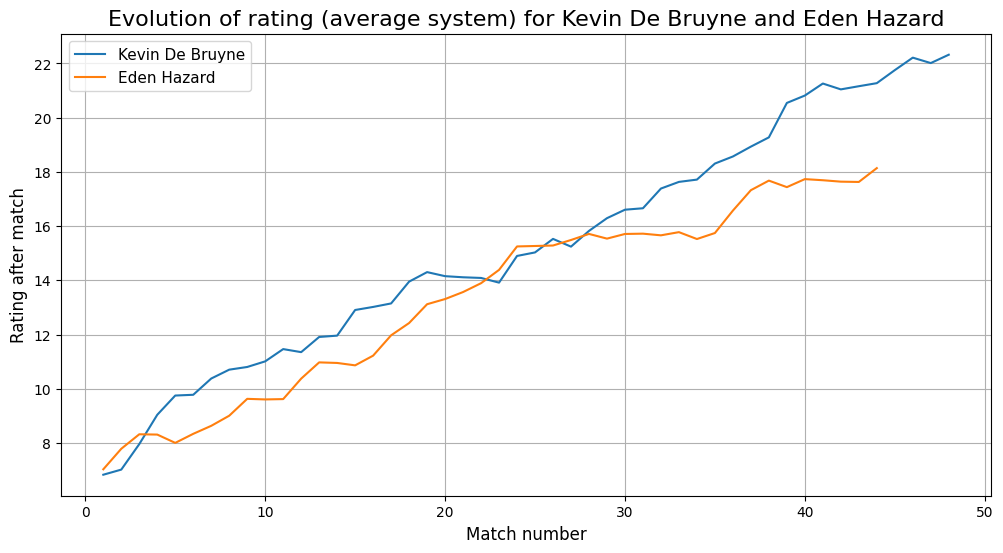

In [48]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne and Eden Hazard in the average system
players = ["Kevin De Bruyne", "Eden Hazard"]
df_plot = ts_avg[ts_avg["player"].isin(players)].copy()

# Add match number per player
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(12, 6))
for player in players:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for Kevin De Bruyne and Eden Hazard")
plt.legend()
plt.grid(True)
plt.show()

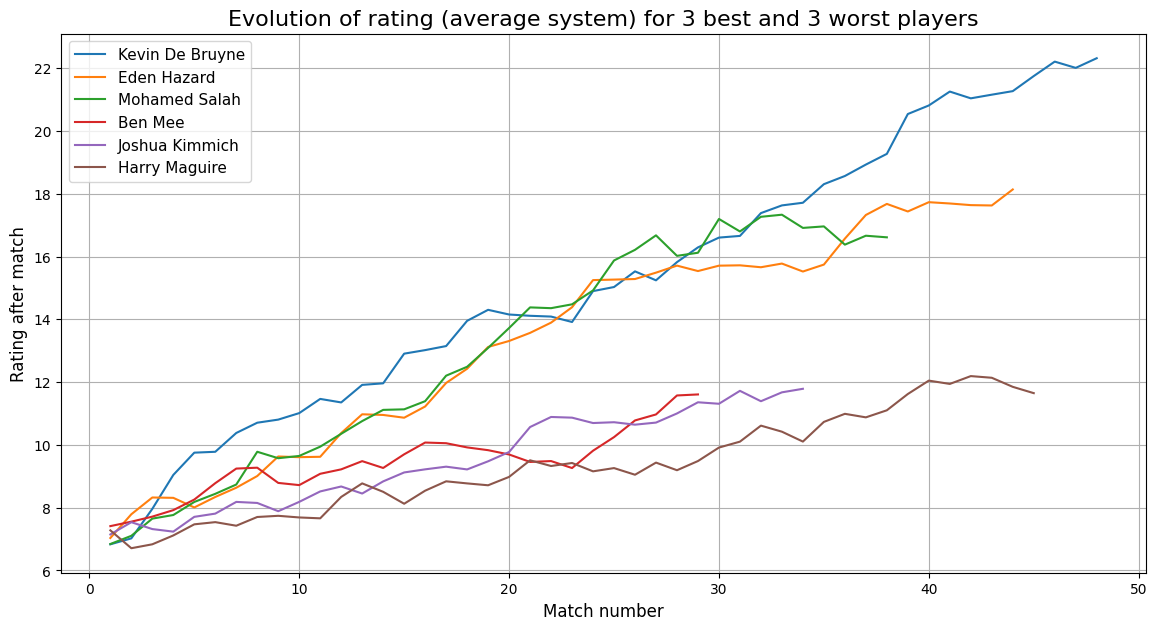

In [49]:
import matplotlib.pyplot as plt

# Get top 3 and bottom 3 players by final_rating
best_players = top_20.head(3)["player"].tolist()
worst_players = top_20.tail(3)["player"].tolist()

# Combine for plotting
players_to_plot = best_players + worst_players

# Filter time series for these players (average system)
df_plot = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(14, 7))
for player in players_to_plot:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for 3 best and 3 worst players")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # how much opponent difficulty shifts expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

def compute_ratings(pm, K=K, diff_impact=DIFF_IMPACT):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    for row in pm.itertuples(index=False):
        player = row.player
        perf   = row.P
        w_min  = row.w_min
        diff   = row.difficulty
        date   = row.date
        match  = row.match

        R_old = player_rating.get(player, BASE_NOTE)

        if pd.isna(perf):
            history.append((date, match, player, R_old, np.nan, np.nan, R_old))
            continue

        E = expected_performance(BASE_NOTE, diff, diff_impact)
        delta = K * w_min * (perf - E)
        R_new = R_old + delta

        player_rating[player] = R_new
        history.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(history, columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep (once)
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty from opponent rank, scaled per competition
max_rank_df = (
    pm0.groupby("competition", dropna=False)["opponent_ranking"]
       .max().rename("max_rank").reset_index()
)
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average of human & non-human (ignores NaNs automatically)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings for each system
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg)
ts_hum, fin_hum = compute_ratings(pm_hum)
ts_ai,  fin_ai  = compute_ratings(pm_ai)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save two CSVs
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

# (optional)
print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")


In [4]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating (target mean)
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # impact of opponent difficulty on expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent (difficulty>0.5) lowers expectation; easier raises it
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

def compute_ratings(pm,
                    K=K,
                    diff_impact=DIFF_IMPACT,
                    keep_global_mean=True,
                    recenter_each_step=False):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    keep_global_mean:
        If True, enforce final (or stepwise) mean rating == BASE_NOTE.
    recenter_each_step:
        If True, re-centers after each date block. Else only one final shift.
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    if recenter_each_step:
        for date, day_df in pm.groupby('date'):
            for row in day_df.itertuples(index=False):
                player = row.player
                perf   = row.P
                w_min  = row.w_min
                diff   = row.difficulty
                match  = row.match
                R_old = player_rating.get(player, BASE_NOTE)

                if pd.isna(perf):
                    history.append((row.date, match, player, R_old, np.nan, np.nan, R_old))
                    continue

                E = expected_performance(BASE_NOTE, diff, diff_impact)
                delta = K * w_min * (perf - E)
                R_new = R_old + delta
                player_rating[player] = R_new
                history.append((row.date, match, player, R_old, perf, E, R_new))

            if keep_global_mean and player_rating:
                current_mean = np.mean(list(player_rating.values()))
                shift = BASE_NOTE - current_mean
                if abs(shift) > 1e-12:
                    # shift stored history entries of this date
                    for i in range(len(history)):
                        d,m,p,Rb,P,E,Ra = history[i]
                        if d == date:
                            history[i] = (d,m,p,Rb+shift,P,E,Ra+shift)
                    # shift live ratings
                    for p in player_rating:
                        player_rating[p] += shift
    else:
        for row in pm.itertuples(index=False):
            player = row.player
            perf   = row.P
            w_min  = row.w_min
            diff   = row.difficulty
            date   = row.date
            match  = row.match
            R_old = player_rating.get(player, BASE_NOTE)

            if pd.isna(perf):
                history.append((date, match, player, R_old, np.nan, np.nan, R_old))
                continue

            E = expected_performance(BASE_NOTE, diff, diff_impact)
            delta = K * w_min * (perf - E)
            R_new = R_old + delta
            player_rating[player] = R_new
            history.append((date, match, player, R_old, perf, E, R_new))

        # Final global recenter
        if keep_global_mean and player_rating:
            final_mean = np.mean(list(player_rating.values()))
            shift = BASE_NOTE - final_mean
            if abs(shift) > 1e-12:
                history = [(d,m,p,Rb+shift,P,E,Ra+shift) for (d,m,p,Rb,P,E,Ra) in history]
                for p in player_rating:
                    player_rating[p] += shift

    ratings_ts = pd.DataFrame(history,
                              columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date","match","player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty (scale opponent_ranking per competition)
max_rank_df = (pm0.groupby("competition", dropna=False)["opponent_ranking"]
                  .max().rename("max_rank").reset_index())
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average (ignores NaNs)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings (final mean preserved at BASE_NOTE)
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg, keep_global_mean=True, recenter_each_step=False)
ts_hum, fin_hum = compute_ratings(pm_hum, keep_global_mean=True, recenter_each_step=False)
ts_ai,  fin_ai  = compute_ratings(pm_ai,  keep_global_mean=True, recenter_each_step=False)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")
print("Global mean (average system) final rating:",
      round(final_all["final_rating_avg"].mean(), 6))

Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv
Global mean (average system) final rating: 6.926722


Best 3: ['Kevin De Bruyne', 'Eden Hazard', 'Mohamed Salah']
Worst 3: ['Bobby Wood', 'Martin Olsson', 'Gideon Jung']


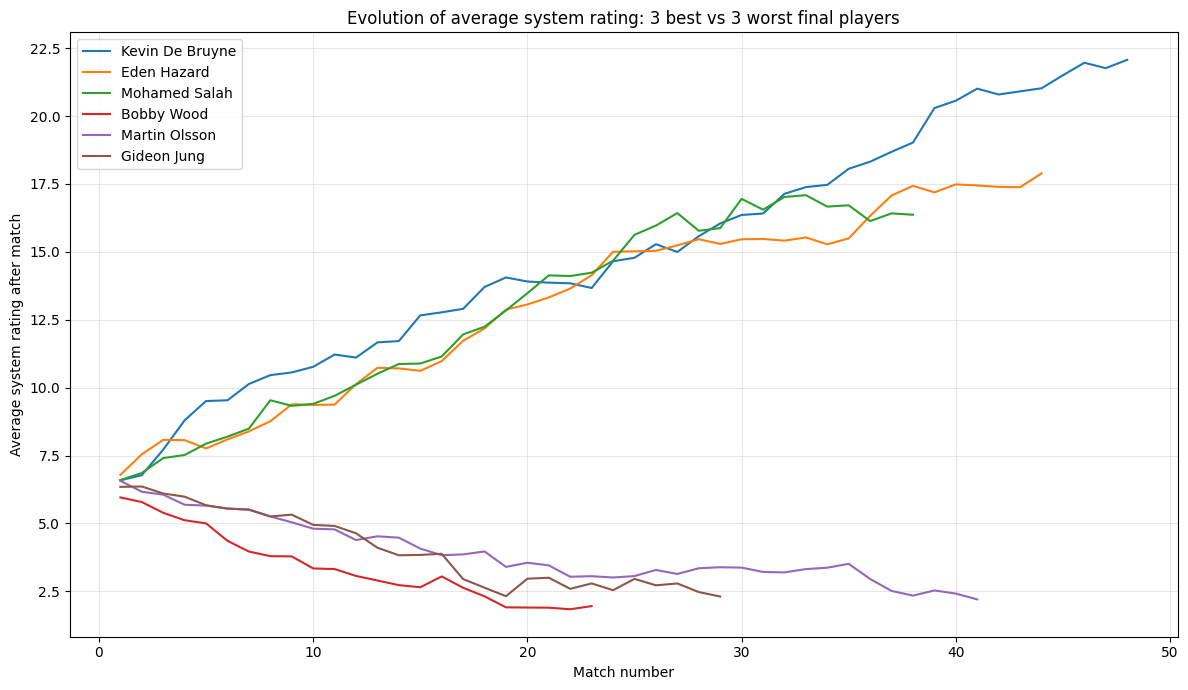

In [6]:
import matplotlib.pyplot as plt

# Select 3 best and 3 worst (average system)
fa_clean = final_all.dropna(subset=["final_rating_avg"])
best_players  = fa_clean.sort_values("final_rating_avg", ascending=False).head(3)["player"].tolist()
worst_players = fa_clean.sort_values("final_rating_avg", ascending=True).head(3)["player"].tolist()
players_to_plot = best_players + worst_players

print("Best 3:", best_players)
print("Worst 3:", worst_players)

# Time series for these players (average system only)
ts_subset = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
# Order by date then compute a per-player match index
ts_subset = ts_subset.sort_values(["player","date","match"])
ts_subset["match_number"] = ts_subset.groupby("player").cumcount() + 1

plt.figure(figsize=(12,7))
for p in players_to_plot:
    d = ts_subset[ts_subset["player"] == p]
    plt.plot(d["match_number"], d["rating_after"], label=p)

plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.title("Evolution of average system rating: 3 best vs 3 worst final players")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Worst 3: ['Bobby Wood', 'Martin Olsson', 'Gideon Jung']
Middle 3: ['Peter Crouch', 'Sebastien Haller', 'Niklas Moisander']
Best 3: ['Kevin De Bruyne', 'Eden Hazard', 'Mohamed Salah']


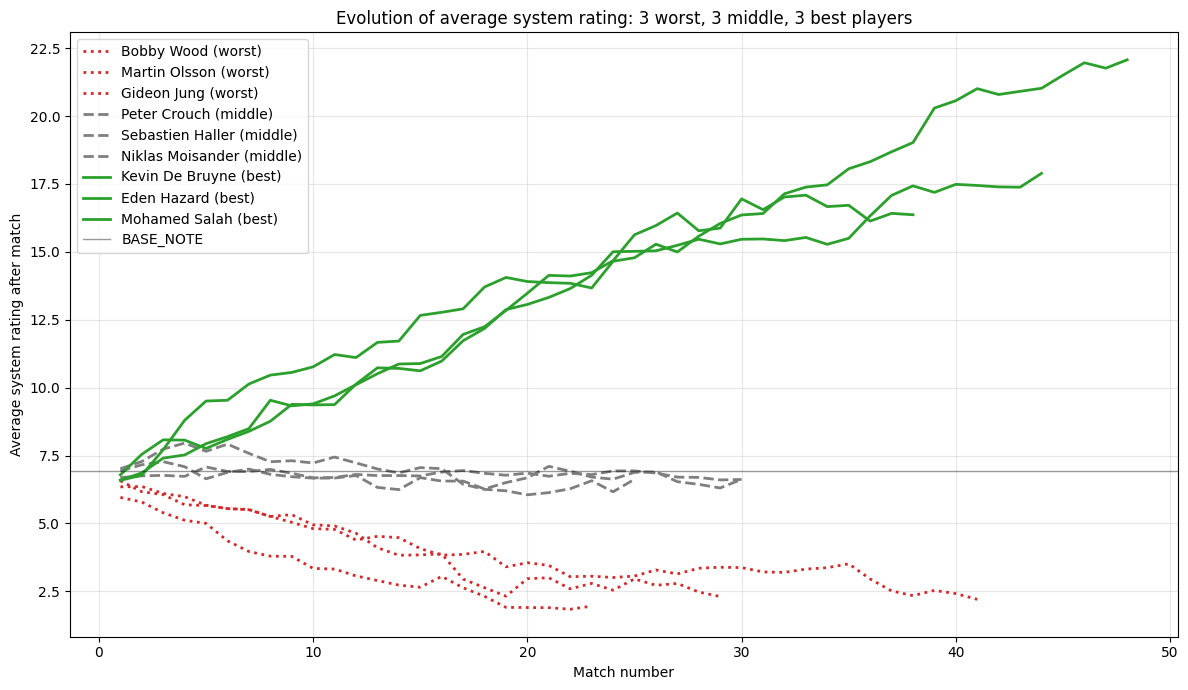

In [7]:
# ...existing code...
import matplotlib.pyplot as plt

# Select 3 best, 3 middle, 3 worst (average system)
fa_clean = final_all.dropna(subset=["final_rating_avg"]).copy()

# Worst (lowest)
worst_players = (fa_clean.sort_values("final_rating_avg", ascending=True)
                          .head(3)["player"].tolist())

# Best (highest)
best_players = (fa_clean.sort_values("final_rating_avg", ascending=False)
                         .head(3)["player"].tolist())

# Middle (around median)
fa_sorted = fa_clean.sort_values("final_rating_avg", ascending=True).reset_index(drop=True)
n = len(fa_sorted)
if n <= 3:
    middle_players = fa_sorted["player"].tolist()  # fallback
else:
    median_idx = n // 2
    candidate_idxs = [median_idx - 1, median_idx, median_idx + 1]
    candidate_idxs = [i for i in candidate_idxs if 0 <= i < n]
    # Ensure exactly 3 if possible
    if len(candidate_idxs) > 3:
        candidate_idxs = candidate_idxs[:3]
    elif len(candidate_idxs) < 3 and n >= 3:
        # pad from center outward
        needed = 3 - len(candidate_idxs)
        extra = []
        for i in range(n):
            if i not in candidate_idxs:
                extra.append(i)
            if len(extra) == needed:
                break
        candidate_idxs += extra
    middle_players = fa_sorted.loc[sorted(candidate_idxs), "player"].tolist()

players_to_plot = worst_players + middle_players + best_players

print("Worst 3:", worst_players)
print("Middle 3:", middle_players)
print("Best 3:", best_players)

# Time series subset (average system)
ts_subset = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
ts_subset = ts_subset.sort_values(["player","date","match"])
ts_subset["match_number"] = ts_subset.groupby("player").cumcount() + 1

# Group assignment
group_map = {}
for p in worst_players:  group_map[p] = "worst"
for p in middle_players: group_map[p] = "middle"
for p in best_players:   group_map[p] = "best"
ts_subset["group"] = ts_subset["player"].map(group_map)

style_cfg = {
    "worst":  {"linestyle":":",  "linewidth":2, "color":"tab:red"},
    "middle": {"linestyle":"--", "linewidth":2, "color":"tab:gray"},
    "best":   {"linestyle":"-",  "linewidth":2, "color":"tab:green"},
}

plt.figure(figsize=(12,7))
for player in players_to_plot:
    d = ts_subset[ts_subset["player"] == player]
    g = group_map[player]
    plt.plot(d["match_number"],
             d["rating_after"],
             label=f"{player} ({g})",
             **style_cfg[g])

# Reference line at BASE_NOTE
plt.axhline(BASE_NOTE, color="black", linewidth=1, alpha=0.4, label="BASE_NOTE")

plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.title("Evolution of average system rating: 3 worst, 3 middle, 3 best players")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#

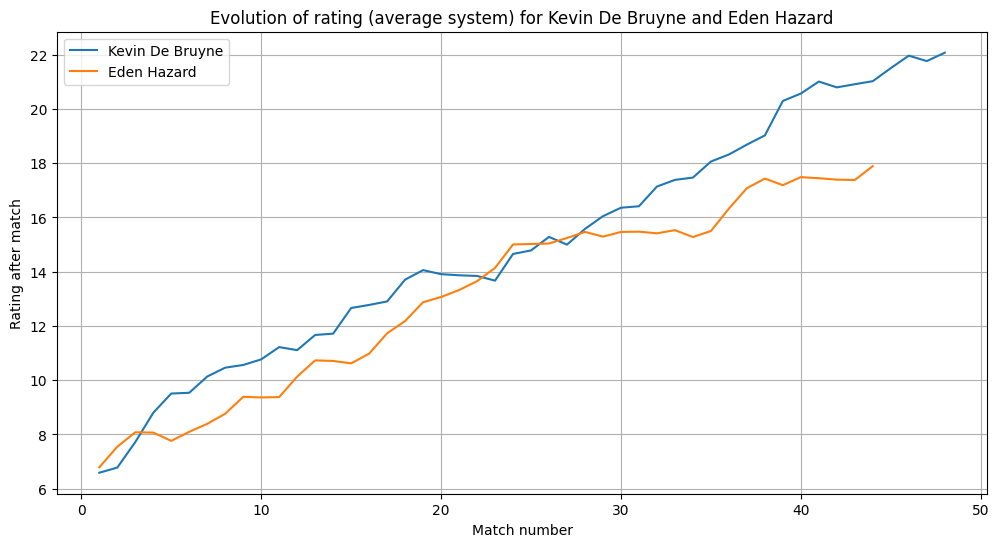

In [9]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne and Eden Hazard in the average system
players = ["Kevin De Bruyne", "Eden Hazard"]
df_plot = ts_avg[ts_avg["player"].isin(players)].copy()

# Add match number per player
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(12, 6))
for player in players:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for Kevin De Bruyne and Eden Hazard")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Show the 10 best players by each rating system
print("Top 10 by average note:")
print(final_all.sort_values("final_rating_avg", ascending=False)[["player", "final_rating_avg"]].head(10))

print("\nTop 5 by human note:")
print(final_all.sort_values("final_rating_human", ascending=False)[["player", "final_rating_human"]].head(5))

print("\nTop 5 by non-human note:")
print(final_all.sort_values("final_rating_ai", ascending=False)[["player", "final_rating_ai"]].head(5))

Top 10 by average note:
                player  final_rating_avg
260    Kevin De Bruyne         22.073854
137        Eden Hazard         17.892492
355      Mohamed Salah         16.367438
285         Leroy Sane         15.446825
178         Harry Kane         15.009783
113        David Silva         14.975194
449      Sergio Aguero         14.850495
413    Raheem Sterling         14.290179
84   Christian Eriksen         14.088380
363              Naldo         12.794977

Top 5 by human note:
              player  final_rating_human
260  Kevin De Bruyne           23.371330
355    Mohamed Salah           17.096383
113      David Silva           16.448999
285       Leroy Sane           15.962055
413  Raheem Sterling           15.765589

Top 5 by non-human note:
              player  final_rating_ai
260  Kevin De Bruyne        20.629166
137      Eden Hazard        20.396293
178       Harry Kane        17.463483
355    Mohamed Salah        15.491280
449    Sergio Aguero        15.162558
